In [ ]:
!nvidia-smi

Thu Jun  9 20:25:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install transformers==4.19.1
!pip install sentencepiece==0.1.96

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 7.6 MB/s 
     |████████████████████████████████| 6.6 MB 52.1 MB/s 
     |████████████████████████████████| 596 kB 55.8 MB/s 
     |████████████████████████████████| 86 kB 7.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 7.5 MB/s 


In [ ]:
# ----------------------------------------------
# Load Libraries
# ----------------------------------------------
import pathlib
from pathlib import Path
import sys
import os
import math
import random
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from transformers import AdamW
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import BertForSequenceClassification, BertConfig, BertModel
from transformers import get_cosine_schedule_with_warmup

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split

from tqdm import tqdm

import gc
gc.enable()

# Config

In [ ]:
class CFG:
    exp_id = 'exp090'
    input_path = 'input/'
    cpc_path = 'input/'
    model_path = 'microsoft/deberta-v3-large'
    out_base = 'output'
    out_path = f'{out_base}/{exp_id}'
    scores_path = f'{out_path}/scores'
    
    debug = False
    fold1_only = False
    upload_dataset = True
    debug_size = 100
    log_interval = 1822 # 未使用
    seed = 42
    max_len = 103
    learning_rate = 2e-5
    weight_decay = 0.01
    lr_decay = 0.98
    num_classes = 1
    num_fold = 4
    epochs = 5
    train_batch_size = 16
    valid_batch_size = 16
    gradient_accumulation_step = 1
    device = "cuda" if torch.cuda.is_available() else "cpu"

    if debug:
      epochs = 1
      upload_dataset = False

    if fold1_only:
      upload_dataset = False

In [ ]:
!mkdir -p {CFG.out_path}
!mkdir -p {CFG.scores_path}

# Preprocess

In [ ]:
# ----------------------------------------------
# Set SEED
# ----------------------------------------------
# seed
SEED = CFG.seed
def set_seed(SEED):
    random.seed(SEED)
    np.random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    
set_seed(SEED)

In [ ]:
train_df = pd.read_csv(f"{CFG.input_path}train.csv")
# https://www.kaggle.com/code/gauravbrills/folds-dump-the-two-paths-fix
cpc_texts = torch.load(CFG.cpc_path+"cpc_texts_fixed.pth")
train_df['context_text'] = train_df['context'].map(cpc_texts)
train_df['context_text'] = "[context=" + train_df['context'] + ']' + train_df['context_text']
train_df['context_text'] = "[subgrp=" + train_df['context'].map(lambda x: x[:1]) + ']' + train_df['context_text']
train_df.head()

,id,anchor,target,context,score,context_text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,[subgrp=A][context=A47]HUMAN NECESSITIES. FURN...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,[subgrp=A][context=A47]HUMAN NECESSITIES. FURN...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,[subgrp=A][context=A47]HUMAN NECESSITIES. FURN...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,[subgrp=A][context=A47]HUMAN NECESSITIES. FURN...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,[subgrp=A][context=A47]HUMAN NECESSITIES. FURN...


In [ ]:
!pip install -q iterative-stratification
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

dfx = pd.get_dummies(train_df, columns=["score"]).groupby(["anchor"], as_index=False).sum()
cols = [c for c in dfx.columns if c.startswith("score_") or c == "anchor"]
dfx = dfx[cols]

mskf = MultilabelStratifiedKFold(n_splits=CFG.num_fold, shuffle=True, random_state=42)
labels = [c for c in dfx.columns if c != "anchor"]
dfx_labels = dfx[labels]
dfx["fold"] = -1

for fold, (trn_, val_) in enumerate(mskf.split(dfx, dfx_labels)):
    print(len(trn_), len(val_))
    dfx.loc[val_, "fold"] = fold

train_df = train_df.merge(dfx[["anchor", "fold"]], on="anchor", how="left")

550 183
549 184
550 183
550 183


In [ ]:
train_df['fold'].value_counts().sort_index()

0    9379
1    8860
2    8612
3    9622
Name: fold, dtype: int64

In [ ]:
print(train_df.shape)
train_df.head()

(36473, 7)


,id,anchor,target,context,score,context_text,fold
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,[subgrp=A][context=A47]HUMAN NECESSITIES. FURN...,0
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,[subgrp=A][context=A47]HUMAN NECESSITIES. FURN...,0
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,[subgrp=A][context=A47]HUMAN NECESSITIES. FURN...,0
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,[subgrp=A][context=A47]HUMAN NECESSITIES. FURN...,0
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,[subgrp=A][context=A47]HUMAN NECESSITIES. FURN...,0


In [ ]:
"""train_df['con_grp'] = train_df['context'].map(lambda x: x[:1])
train_df.groupby('fold')['con_grp'].value_counts().sort_index()"""

"train_df['con_grp'] = train_df['context'].map(lambda x: x[:1])\ntrain_df.groupby('fold')['con_grp'].value_counts().sort_index()"

In [ ]:
train_df['input'] = train_df['anchor'] + '[SEP]' + train_df['target'] + '[SEP]' + train_df['context_text']

In [ ]:
train_df.head()

,id,anchor,target,context,score,context_text,fold,input
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,[subgrp=A][context=A47]HUMAN NECESSITIES. FURN...,0,abatement[SEP]abatement of pollution[SEP][subg...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,[subgrp=A][context=A47]HUMAN NECESSITIES. FURN...,0,abatement[SEP]act of abating[SEP][subgrp=A][co...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,[subgrp=A][context=A47]HUMAN NECESSITIES. FURN...,0,abatement[SEP]active catalyst[SEP][subgrp=A][c...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,[subgrp=A][context=A47]HUMAN NECESSITIES. FURN...,0,abatement[SEP]eliminating process[SEP][subgrp=...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,[subgrp=A][context=A47]HUMAN NECESSITIES. FURN...,0,abatement[SEP]forest region[SEP][subgrp=A][con...


# Tokenizer

In [ ]:
subgrp = train_df['context'].map(lambda x: x[:1]).unique()

tokenizer = AutoTokenizer.from_pretrained(CFG.model_path)
tokenizer.add_tokens([f"[context={i}]" for i in cpc_texts.keys()])
tokenizer.add_tokens([f"[subgrp={i}]" for i in subgrp])
len(tokenizer)

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/580 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.35M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.7/dist-packages/transformers/convert_slow_tokenizer.py:435: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  "The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option"
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


128145

count    36473.000000
mean        29.642996
std         12.722325
min         13.000000
25%         20.000000
50%         26.000000
75%         37.000000
max        103.000000
Name: input, dtype: float64

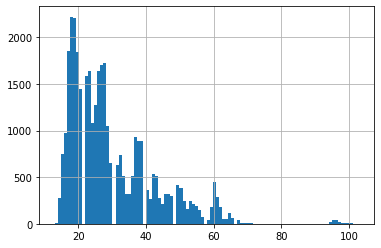

In [ ]:
# トークン長分布の確認
token_len = train_df['input'].map(lambda x: tokenizer(x)['input_ids'].__len__())
display(token_len.describe())
token_len.hist(bins=100)

# Dataset

In [ ]:
def prepare_input(tokenizer, text):
    inputs = tokenizer(text,
                           add_special_tokens=True,
                           max_length=CFG.max_len,
                           padding="max_length",
                           truncation=True,
                           return_offsets_mapping=False)
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs


class TrainDataset(Dataset):
    def __init__(self, df):
        self.inputs = df['input'].values
        self.label = df['score'].values

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, item):
        inputs = self.inputs[item]
        label = self.label[item]
        outputs = prepare_input(tokenizer, inputs)
        outputs['label'] = torch.tensor(label, dtype=torch.float32)

        return outputs

# Train

In [ ]:
# ----------------------------------------------
# Model
# ----------------------------------------------
class AttentionHead(nn.Module):
    def __init__(self, in_features, hidden_dim, num_targets):
        super().__init__()
        self.in_features = in_features
        self.middle_features = hidden_dim
        self.W = nn.Linear(in_features, hidden_dim)
        self.V = nn.Linear(hidden_dim, 1)
        self.out_features = hidden_dim

    def forward(self, features):
        att = torch.tanh(self.W(features))
        score = self.V(att)
        attention_weights = torch.softmax(score, dim=1)
        context_vector = attention_weights * features
        context_vector = torch.sum(context_vector, dim=1)

        return context_vector

class PPPMModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.num_reinit_layers = 6
        self.config = AutoConfig.from_pretrained(CFG.model_path)
        self.config.attention_probs_dropout_prob = 0.0
        self.config.hidden_dropout_prob = 0.0
        self.pre_model = AutoModel.from_pretrained(CFG.model_path, config=self.config)
        self.pre_model.resize_token_embeddings(len(tokenizer))
        self.head = AttentionHead(self.config.hidden_size, self.config.hidden_size,1)
        #self.dropout = nn.Dropout(0.3)
        self.regressor = nn.Linear(self.config.hidden_size, CFG.num_classes)
        #self.initialize()
    
    def forward(self, inputs):
        pre_out = self.pre_model(**inputs)
        x = pre_out[0]
        x = self.head(x)
        x = self.regressor(x)
        return x
  
    def initialize(self):
      for i in range(self.num_reinit_layers):
          self.pre_model.encoder.layer[-(1 + i)].apply(self._init_weight)

    def _init_weight(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.pre_model.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()

In [ ]:
# ----------------------------------------------
# func: valid, predict
# ----------------------------------------------
def predict(model, dataloader):
    model.eval()
    result = np.zeros((len(dataloader.dataset), CFG.num_classes))
    idx = 0
    
    with torch.no_grad():
        for batch_idx, data in enumerate(dataloader):
          inputs = {}
          for k, v in data.items():
            inputs[k] = v.to(CFG.device)            
          output = model(inputs)
          result[idx:idx + output.shape[0], :] = output.to('cpu')
          idx += output.shape[0]
            
    return result


def valid_mse(model, dataloader):
    model.eval()
    result = np.zeros((len(dataloader.dataset), CFG.num_classes))
    idx = 0
    mse_sum = 0
    bar = tqdm(dataloader, total=len(dataloader))
    
    with torch.no_grad():
        for batch_idx, data in enumerate(bar):
          inputs = {}
          for k, v in data.items():
            if k != 'label':
              inputs[k] = v.to(CFG.device)            
          label = data['label'].to(CFG.device)          
          output = model(inputs)
          result[idx:idx + output.shape[0], :] = output.to('cpu')
          idx += output.shape[0]

          mse_sum += nn.MSELoss(reduction='sum')(output.flatten(), label).item()
            
    return mse_sum/(len(dataloader.dataset)), result.reshape(len(result))


def metric_pearson(predictions, labels):
    pearson = np.corrcoef(predictions, labels)[0][1]       
    return pearson

In [ ]:
# ----------------------------------------------
# func: train
# ----------------------------------------------
def train_fn(
    model,
    save_path,
    train_loader,
    val_loader,
    optimizer,
    scheduler=None,
    num_epochs=CFG.epochs
):

    best_score = 0
    best_epoch = 0
    running_loss = 0.0
    dataset_size = 0
    log_interval = CFG.log_interval
    oof_preds = None

    start = time.time()

    for epoch in range(num_epochs):
        val_score = None
        model.train()
        bar = tqdm(train_loader, total=len(train_loader))
        for batch_idx, data in enumerate(bar):
          inputs = {}
          for k, v in data.items():
            if k != 'label':
              inputs[k] = v.to(CFG.device)            
          label = data['label'].to(CFG.device)
          batch_size = label.size(0)

          output = model(inputs)
          loss = nn.MSELoss()(output.flatten(), label)
          loss = loss / CFG.gradient_accumulation_step

          loss.backward()

          if (batch_idx + 1) % CFG.gradient_accumulation_step == 0:
            optimizer.step()
            optimizer.zero_grad()
            if scheduler:
                scheduler.step()

          if CFG.debug == True:
            if (batch_idx > 0) & (batch_idx % CFG.debug_size == 0):
                break

          running_loss += (loss.item() * batch_size)
          dataset_size += batch_size            
          total_loss = running_loss / dataset_size
          bar.set_postfix(Epoch=epoch, Loss=loss.item(), TotalLoss=total_loss, LR=optimizer.param_groups[0]['lr'])

        val_start = time.time()
        val_score, predictions = valid_mse(model, val_loader)
        pearson = metric_pearson(predictions, val_loader.dataset.label)
        print(f"Epoch {epoch+1}, Step {batch_idx+1}, train_loss: {loss:0.5f}, val_loss: {val_score:0.5f}, pearson: {pearson:0.5f}")
        if pearson > best_score:
            print(f"Model Inproved: {best_score} ----> {pearson}")
            best_score = pearson
            oof_preds = predictions
            torch.save(model.state_dict(), save_path)
        print(f"validation elasped time: {time.time() - val_start: 0.3}")

    print(f"total elasped time: {time.time() - start: 0.3}")
    start = time.time()

    return best_score, oof_preds

# ----------------------------------------------
# create optimizer
# ----------------------------------------------
def create_optimizer(model):
    named_params = list(model.named_parameters())
    no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
    optim_params = []
    for idx_, (name_, params_) in enumerate(named_params):
        weight_decay = 0 if name_ in no_decay else 0.01
        optim_params.append({'params':params_,
                            'weight_decay': weight_decay,
                            })

    return AdamW(optim_params)


# https://www.ai-shift.co.jp/techblog/2145
def create_optimizer_grouped_parameters(model):
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters()
                       if 'lstm' in n
                       or 'cnn' in n
                       or 'regressor' in n],
            "weight_decay": 0.0,
            "lr": 1e-3,
        },
    ]
    num_layers = model.config.num_hidden_layers
    layers = [getattr(model, 'pre_model').embeddings] + list(getattr(model, 'pre_model').encoder.layer)
    layers.reverse()
    lr = CFG.learning_rate
    for layer in layers:
        lr *= CFG.lr_decay
        optimizer_grouped_parameters += [
            {
                "params": [p for n, p in layer.named_parameters() if not any(nd in n for nd in no_decay)],
                "weight_decay": CFG.weight_decay,
                "lr": lr,
            },
            {
                "params": [p for n, p in layer.named_parameters() if any(nd in n for nd in no_decay)],
                "weight_decay": 0.0,
                "lr": lr,
            },
        ]
    return AdamW(optimizer_grouped_parameters)


In [ ]:
# ----------------------------------------------
# Main Loop
# ----------------------------------------------
val_scores = []
oof_df = pd.DataFrame()

for fold in range(CFG.num_fold): 
    print(f"*** FOLD {fold+1} / {CFG.num_fold}***")

    save_path = f"{CFG.out_path}/model_{fold+1}.pth"

    train_data = train_df[train_df['fold'] != fold]
    valid_data = train_df[train_df['fold'] == fold]
    train_set = TrainDataset(train_data)
    valid_set = TrainDataset(valid_data)

    train_loader = DataLoader(train_set,
                            batch_size=CFG.train_batch_size,
                            shuffle=True,
                            drop_last=True,
                            num_workers=2,
                            pin_memory=True)
    valid_loader = DataLoader(valid_set,
                            batch_size=CFG.valid_batch_size,
                            shuffle=False,
                            drop_last=False,
                            num_workers=2,
                            pin_memory=True)

    model = PPPMModel().to(CFG.device)
    optimizer = create_optimizer_grouped_parameters(model)
    #optimizer = AdamW(model.parameters(), lr=CFG.learning_rate)
    scheduler = get_cosine_schedule_with_warmup(
        optimizer,
        num_training_steps=CFG.epochs*len(train_loader),
        num_warmup_steps=100
    )

    val_score, val_preds = train_fn(model, save_path, train_loader, valid_loader, optimizer, scheduler=scheduler)

    val_scores.append(val_score)
    valid_data['preds'] = val_preds
    oof_df = pd.concat([oof_df, valid_data])

    del model
    torch.cuda.empty_cache()

    print(val_scores)
    print("Mean:", np.array(val_scores).mean())
    if CFG.fold1_only == True:
        if fold == 0:
            break

*** FOLD 1 / 4***


Downloading:   0%|          | 0.00/833M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.LayerNorm.weight', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/pytho

Epoch 1, Step 1693, train_loss: 0.03383, val_loss: 0.02132, pearson: 0.83015
Model Inproved: 0 ----> 0.8301544536682924
validation elasped time:  1.32e+02


100%|██████████| 587/587 [02:04<00:00,  4.73it/s]


Epoch 2, Step 1693, train_loss: 0.01019, val_loss: 0.02115, pearson: 0.83272
Model Inproved: 0.8301544536682924 ----> 0.8327175926128816
validation elasped time:  1.32e+02


100%|██████████| 587/587 [02:04<00:00,  4.72it/s]


Epoch 3, Step 1693, train_loss: 0.00344, val_loss: 0.01974, pearson: 0.83862
Model Inproved: 0.8327175926128816 ----> 0.8386189796640232
validation elasped time:  1.34e+02


100%|██████████| 587/587 [02:03<00:00,  4.75it/s]


Epoch 4, Step 1693, train_loss: 0.00530, val_loss: 0.02041, pearson: 0.83506
validation elasped time:  1.24e+02


100%|██████████| 587/587 [02:03<00:00,  4.77it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 5, Step 1693, train_loss: 0.00097, val_loss: 0.02027, pearson: 0.83598
validation elasped time:  1.23e+02
total elasped time:  6.44e+03
[0.8386189796640232]
Mean: 0.8386189796640232
*** FOLD 2 / 4***


Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.LayerNorm.weight', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 554

Epoch 1, Step 1725, train_loss: 0.01730, val_loss: 0.02476, pearson: 0.81384
Model Inproved: 0 ----> 0.8138409543894086
validation elasped time:  1.24e+02


100%|██████████| 554/554 [01:56<00:00,  4.76it/s]


Epoch 2, Step 1725, train_loss: 0.00744, val_loss: 0.02264, pearson: 0.81363
validation elasped time:  1.16e+02


100%|██████████| 554/554 [01:56<00:00,  4.77it/s]


Epoch 3, Step 1725, train_loss: 0.00249, val_loss: 0.02233, pearson: 0.82374
Model Inproved: 0.8138409543894086 ----> 0.8237367773117672
validation elasped time:  1.24e+02


100%|██████████| 554/554 [01:56<00:00,  4.77it/s]


Epoch 4, Step 1725, train_loss: 0.00310, val_loss: 0.02212, pearson: 0.82090
validation elasped time:  1.16e+02


100%|██████████| 554/554 [01:56<00:00,  4.77it/s]


Epoch 5, Step 1725, train_loss: 0.00062, val_loss: 0.02244, pearson: 0.81860
validation elasped time:  1.16e+02
total elasped time:  6.49e+03


Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.LayerNorm.weight', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[0.8386189796640232, 0.8237367773117672]
Mean: 0.8311778784878951
*** FOLD 3 / 4***


100%|██████████| 539/539 [01:52<00:00,  4.77it/s]


Epoch 1, Step 1741, train_loss: 0.01236, val_loss: 0.02113, pearson: 0.83383
Model Inproved: 0 ----> 0.8338255144961747
validation elasped time:  1.21e+02


100%|██████████| 539/539 [01:52<00:00,  4.77it/s]


Epoch 2, Step 1741, train_loss: 0.00649, val_loss: 0.02148, pearson: 0.83331
validation elasped time:  1.13e+02


100%|██████████| 539/539 [01:52<00:00,  4.78it/s]


Epoch 3, Step 1741, train_loss: 0.01074, val_loss: 0.02179, pearson: 0.84070
Model Inproved: 0.8338255144961747 ----> 0.840699226742761
validation elasped time:  1.21e+02


100%|██████████| 539/539 [01:53<00:00,  4.76it/s]


Epoch 4, Step 1741, train_loss: 0.00295, val_loss: 0.02052, pearson: 0.83893
validation elasped time:  1.13e+02


100%|██████████| 539/539 [01:53<00:00,  4.75it/s]


Epoch 5, Step 1741, train_loss: 0.00146, val_loss: 0.02080, pearson: 0.83645
validation elasped time:  1.13e+02
total elasped time:  6.53e+03
[0.8386189796640232, 0.8237367773117672, 0.840699226742761]
Mean: 0.8343516612395171
*** FOLD 4 / 4***


Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.LayerNorm.weight', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 602

Epoch 1, Step 1678, train_loss: 0.01412, val_loss: 0.02641, pearson: 0.79646
Model Inproved: 0 ----> 0.796461625178024
validation elasped time:  1.35e+02


100%|██████████| 602/602 [02:06<00:00,  4.78it/s]


Epoch 2, Step 1678, train_loss: 0.01026, val_loss: 0.02245, pearson: 0.81232
Model Inproved: 0.796461625178024 ----> 0.8123199636450181
validation elasped time:  1.34e+02


100%|██████████| 602/602 [02:06<00:00,  4.77it/s]


Epoch 3, Step 1678, train_loss: 0.00286, val_loss: 0.02198, pearson: 0.81695
Model Inproved: 0.8123199636450181 ----> 0.8169477326992357
validation elasped time:  1.34e+02


100%|██████████| 602/602 [02:05<00:00,  4.78it/s]


Epoch 4, Step 1678, train_loss: 0.00215, val_loss: 0.02259, pearson: 0.81373
validation elasped time:  1.26e+02


100%|██████████| 602/602 [02:05<00:00,  4.78it/s]


Epoch 5, Step 1678, train_loss: 0.00142, val_loss: 0.02277, pearson: 0.81221
validation elasped time:  1.26e+02
total elasped time:  6.38e+03
[0.8386189796640232, 0.8237367773117672, 0.840699226742761, 0.8169477326992357]
Mean: 0.8300006791044467


In [ ]:
"""for batch_idx, data in enumerate(valid_loader):
  print(batch_idx)
"""

'for batch_idx, data in enumerate(valid_loader):\n  print(batch_idx)\n'

In [ ]:
scores = {f'fold{i}':j for i,j in enumerate(val_scores)}
scores['oof'] = np.corrcoef(oof_df['preds'], oof_df['score'])[0][1]
scores = pd.Series(scores)
print(scores)

fold0    0.838619
fold1    0.823737
fold2    0.840699
fold3    0.816948
oof      0.827715
dtype: float64


In [ ]:
scores.to_csv(f'{CFG.out_path}/scores.csv')
oof_df.to_csv(f'{CFG.out_path}/oof_df.csv')